## Parameter estimation with discovery and numpyro

Creating MCMC chains with discovery likelihoods and `numpyro`'s [NUTS sampler](https://num.pyro.ai/en/latest/mcmc.html).

Obviously, `discovery.samplers.numpyro` requires `numpyro`.

In [1]:
import sys
import os
import glob

import tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

%matplotlib inline

In [3]:
import jax
jax.config.update('jax_enable_x64', True)

import jax.random
import jax.numpy as jnp

In [4]:
import discovery as ds
import discovery.models.nanograv as ds_nanograv
import discovery.samplers.numpyro as ds_numpyro

Read nanograv pulsars

In [32]:
allpsrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob('../data/*-[JB]*.feather'))]

Run with fewer pulsars to converge on GPU

In [6]:
allpsrs = allpsrs[:5]

Set up a NANOGrav CURN model. Possible options to `makemodel_curn` are `rn_components`, `crn_components`, and `gamma=<fixed_value>`. For an HD model, use `ds_nanograv.makemodel_hd`.

In [12]:
model = ds_nanograv.makemodel_curn(allpsrs)

Obtain the likelihood

In [16]:
logl = model.logL

These are the parameters.

In [17]:
logl.params

['B1855+09_red_noise_gamma',
 'B1855+09_red_noise_log10_A',
 'B1937+21_red_noise_gamma',
 'B1937+21_red_noise_log10_A',
 'B1953+29_red_noise_gamma',
 'B1953+29_red_noise_log10_A',
 'J0023+0923_red_noise_gamma',
 'J0023+0923_red_noise_log10_A',
 'J0030+0451_red_noise_gamma',
 'J0030+0451_red_noise_log10_A',
 'crn_gamma',
 'crn_log10_A']

Sample parameter values from their default uniform priors.

In [18]:
p0 = ds.sample_uniform(logl.params)

Try likelihood, compiled version, likelihood gradient.

In [20]:
logl(p0)

Array(914691.13889637, dtype=float64)

In [21]:
jax.jit(logl)(p0)

Array(914691.13889637, dtype=float64)

In [22]:
jax.grad(logl)(p0)

{'B1855+09_red_noise_gamma': Array(-0.0009749, dtype=float64, weak_type=True),
 'B1855+09_red_noise_log10_A': Array(-0.00166683, dtype=float64, weak_type=True),
 'B1937+21_red_noise_gamma': Array(-0.0004357, dtype=float64, weak_type=True),
 'B1937+21_red_noise_log10_A': Array(-0.00086616, dtype=float64, weak_type=True),
 'B1953+29_red_noise_gamma': Array(-0.01444272, dtype=float64, weak_type=True),
 'B1953+29_red_noise_log10_A': Array(-0.02485109, dtype=float64, weak_type=True),
 'J0023+0923_red_noise_gamma': Array(-4.61835094e-11, dtype=float64, weak_type=True),
 'J0023+0923_red_noise_log10_A': Array(-9.62121944e-11, dtype=float64, weak_type=True),
 'J0030+0451_red_noise_gamma': Array(-0.00069229, dtype=float64, weak_type=True),
 'J0030+0451_red_noise_log10_A': Array(-0.00137895, dtype=float64, weak_type=True),
 'crn_gamma': Array(-25.50380024, dtype=float64, weak_type=True),
 'crn_log10_A': Array(-504.46209096, dtype=float64, weak_type=True)}

Make a numpyro model, transforming likelihood to standard `[-inf, inf]` parameter ranges.

In [23]:
npmodel = ds_numpyro.makemodel_transformed(logl)

Make a numpyro NUTS sampler object. Numypro arguments for `infer.MCMC` and `infer.NUTS` are supported.

In [27]:
npsampler = ds_numpyro.makesampler_nuts(npmodel)

Run with a set random seed.

In [28]:
npsampler.run(jax.random.PRNGKey(42))

sample: 100%|███████████████████████████████████████████████████████████████████████████| 1536/1536 [00:53<00:00, 28.91it/s, 31 steps of size 1.37e-01. acc. prob=0.85]


`discovery` enhances the `numpyro` sampler with a method `to_df()` that returns the sampler chain as a pandas `DataFrame`.

In [29]:
chain = npsampler.to_df()

In [31]:
chain

,B1855+09_red_noise_gamma,B1855+09_red_noise_log10_A,B1937+21_red_noise_gamma,B1937+21_red_noise_log10_A,B1953+29_red_noise_gamma,B1953+29_red_noise_log10_A,J0023+0923_red_noise_gamma,J0023+0923_red_noise_log10_A,J0030+0451_red_noise_gamma,J0030+0451_red_noise_log10_A,crn_gamma,crn_log10_A
0,6.476984,-18.148467,4.089248,-13.520661,1.075246,-12.642510,5.500433,-18.054510,0.494193,-15.080699,4.255313,-14.181534
1,0.013168,-16.318226,3.942949,-13.649348,4.265511,-13.434208,1.890570,-13.717133,5.991677,-18.095588,3.959131,-14.168350
2,0.008013,-17.412356,4.291904,-13.584551,4.502505,-13.422527,2.607725,-16.042287,5.190236,-17.986991,3.985542,-14.211795
3,2.891030,-17.814518,4.211965,-13.615802,0.395461,-12.660168,4.132601,-19.332417,0.611211,-17.589698,3.217800,-13.794063
4,2.965423,-15.693120,3.741948,-13.572435,0.256944,-12.584014,0.387995,-19.913435,6.216158,-17.504121,3.778628,-13.996851
...,...,...,...,...,...,...,...,...,...,...,...,...
1019,2.442326,-18.021231,4.636352,-13.734986,2.430792,-13.031007,4.129197,-16.518822,2.839567,-19.432986,3.057165,-13.757071
1020,2.880649,-18.471594,4.405029,-13.796660,2.809793,-13.066353,4.538688,-16.337045,1.827672,-19.730748,3.071215,-13.836040
1021,5.352179,-19.604518,4.404296,-13.660947,2.805014,-13.006893,3.836079,-16.749440,1.109886,-18.662330,3.386114,-13.757132
1022,3.455395,-16.677092,3.856385,-13.595281,2.120671,-12.838609,1.916079,-14.054348,2.648604,-18.986566,3.253295,-13.718977


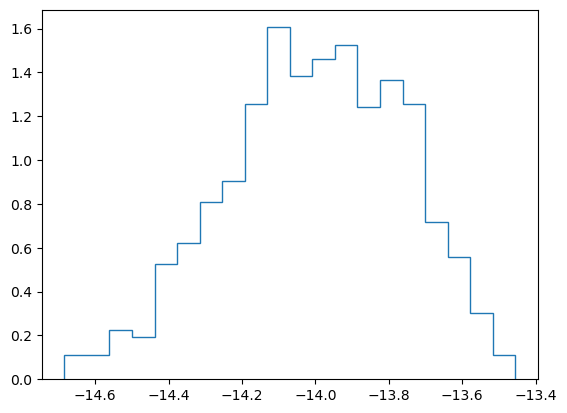

In [34]:
pp.hist(chain['crn_log10_A'], bins=20, histtype='step', density=True);

## Experimenting with FFTint

In [33]:
allpsrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob('../data/*-[JB]*.feather'))]

In [67]:
tspan = ds.getspan(allpsrs)

onesm = lambda psr: ds.PulsarLikelihood([psr.residuals,
                                         ds.makenoise_measurement(psr, psr.noisedict),
                                         ds.makegp_ecorr(psr, psr.noisedict),
                                         ds.makegp_timing(psr, svd=True),
                                         ds.makegp_fftcov(psr, ds.powerlaw, 61, tspan, oversample=6, name='rednoise')])

onegm = lambda allpsrs: ds.GlobalLikelihood([onesm(psr) for psr in allpsrs],
                                            globalgp=ds.makeglobalgp_fftcov(allpsrs, ds.powerlaw, ds.hd_orf, 61,
                                                                            T=tspan, oversample=6, name='gw'))

In [101]:
%time logl = onegm(allpsrs[:30]).logL

CPU times: user 29.3 s, sys: 29.7 s, total: 59 s
Wall time: 6.94 s


In [102]:
p0 = ds.sample_uniform(logl.params)

In [103]:
%time logl(p0).block_until_ready()

CPU times: user 172 ms, sys: 342 ms, total: 514 ms
Wall time: 92.9 ms


Array(3517956.48725933, dtype=float64)

In [94]:
%timeit logl(p0).block_until_ready()

316 ms ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [107]:
jlogl = jax.jit(jax.value_and_grad(logl))

In [111]:
%time jlogl(p0)[0].block_until_ready()

CPU times: user 759 ms, sys: 818 ms, total: 1.58 s
Wall time: 195 ms


Array(3517956.48725926, dtype=float64)

In [113]:
%timeit jlogl(p0)[0].block_until_ready()

175 ms ± 2.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [2477]:
import importlib

importlib.reload(ds.matrix)
importlib.reload(ds.signals)
importlib.reload(ds.likelihood)
importlib.reload(ds)

<module 'discovery' from '/Users/vallis/Documents/discovery/src/discovery/__init__.py'>

In [2478]:
tspan = ds.getspan(allpsrs)

onesm = lambda psr: ds.PulsarLikelihood([psr.residuals,
                                         ds.makenoise_measurement(psr, psr.noisedict),
                                         ds.makegp_ecorr(psr, psr.noisedict),
                                         ds.makegp_timing(psr, svd=True)])

onegm = lambda allpsrs: ds.ArrayLikelihood([onesm(psr) for psr in allpsrs],
                                           commongp=ds.makecommongp_fftcov(allpsrs, ds.powerlaw, 61,
                                                                           T=tspan, oversample=6, name='rednoise'), 
                                           globalgp=ds.makeglobalgp_fftcov(allpsrs, ds.powerlaw, ds.hd_orf, 61,
                                                                           T=tspan, oversample=6, name='gw'))

In [2479]:
%time model = onegm(allpsrs[:10])

CPU times: user 22.5 s, sys: 12.7 s, total: 35.2 s
Wall time: 3.73 s


In [2396]:
clogl1 = model.cglogL(100, 5, 200, make_logdet='CG-Woodbury')
clogl2 = model.cglogL(100, 5, 200, make_logdet='CG-MDL')
clogl3 = model.cglogL(100, 5, 200, make_logdet='G-series')
clogl4 = model.cglogL(100, 5, 200, make_logdet='D-series')

In [2481]:
jlogl = jax.jit(model.logL)
clogl1 = jax.jit(model.cglogL(100, detmatvecs=5, detsamples=200, clip=1e-6, make_logdet='CG-Woodbury'))
clogl2 = jax.jit(model.cglogL(100, detmatvecs=5, detsamples=200, clip=1e-6, make_logdet='CG-MDL'))
clogl3 = jax.jit(model.cglogL(100, detmatvecs=5, detsamples=200, make_logdet='G-series'))
clogl4 = jax.jit(model.cglogL(100, detmatvecs=5, detsamples=200, make_logdet='D-series'))

In [2482]:
p0s, cls = [], []
for i in tqdm.tqdm(range(1000)):
    p0 = ds.sample_uniform(model.logL.params)
    p0s.append(p0)
    cls.append([jlogl(p0), clogl1(p0), clogl2(p0), clogl3(p0), clogl4(p0)])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:15<00:00, 13.30it/s]


In [ ]:
cls2 = []
for i in tqdm.tqdm(range(1000)):
    cls2.append([jlogl(p0), clogl1(p0), clogl2(p0), clogl3(p0), clogl4(p0)])

In [2446]:
cls = jnp.array(cls)

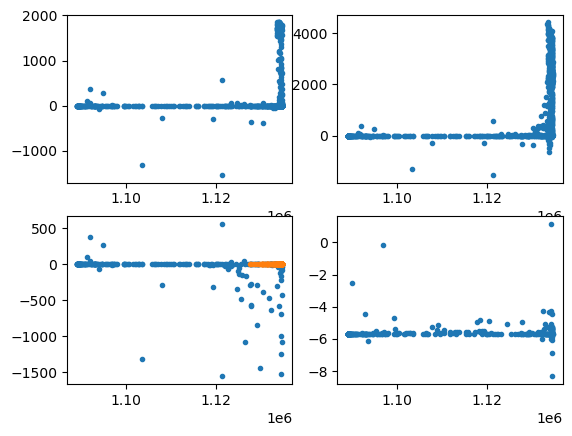

In [2475]:
pp.subplot(2,2,1); pp.plot(cls[:,0], cls[:,1] - cls[:,0], '.')
pp.subplot(2,2,2); pp.plot(cls[:,0], cls[:,2] - cls[:,0], '.')

mask = jnp.abs(cls[:,3] - cls[:,0]) < 2000
pp.subplot(2,2,3); pp.plot(cls[mask,0], cls[mask,3] - cls[mask,0], '.')
pp.plot(cls[~mask,0], jnp.zeros(jnp.sum(~mask)), '.')

pp.subplot(2,2,4)
# pp.plot(cls[:,0], cls[:,4] - cls[:,0], '.')
mask = jnp.abs(cls[:,3] - cls[:,0]) < 10
pp.plot(cls[mask,0], cls[mask,4] - cls[mask,0], '.')

In [2452]:
jnp.isnan(cls[:,3])

Array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [2347]:
%timeit clogl1(p0)

23.4 ms ± 125 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [2348]:
%timeit clogl2(p0)

19.6 ms ± 2.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [2349]:
%timeit clogl3(p0)

9.56 ms ± 121 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [2350]:
%timeit clogl4(p0)

10.2 ms ± 46.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [2357]:
glogl1 = jax.jit(jax.grad(model.cglogL(100, 5, 200, make_logdet='CG-Woodbury')))
glogl2 = jax.jit(jax.grad(model.cglogL(100, 5, 200, make_logdet='CG-MDL')))
glogl3 = jax.jit(jax.grad(model.cglogL(100, 5, 200, make_logdet='G-series')))
glogl4 = jax.jit(jax.grad(model.cglogL(100, 5, 200, make_logdet='D-series')))

In [2362]:
%timeit glogl1(p0)['B1855+09_rednoise_gamma']

85.4 ms ± 424 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [2363]:
%timeit glogl2(p0)['B1855+09_rednoise_gamma']

62.8 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [2364]:
%timeit glogl3(p0)['B1855+09_rednoise_gamma']

32.2 ms ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [2365]:
%timeit glogl4(p0)['B1855+09_rednoise_gamma']

25.8 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


clogl(p0)

In [1428]:
jnpa, jspa = jax.numpy.linalg, jax.scipy.linalg

orfcf, phicf, FtNmF = clogl(p0)

In [1213]:
orfmat = orfcf[0].T @ orfcf[0]

In [1214]:
phimat = phicf[0].T @ phicf[0]

In [1431]:
phiinv = jspa.cho_solve(phicf, jnp.eye(61))

In [ ]:
orfinv = jspa.cho_solve(orfcf, jax.numpy.eye(5))

Try CG approach

In [1891]:
Y = np.random.randn(5,61)

In [1907]:
AY = jnp.einsum('akl,al->ak', FtNmF, jnp.einsum('ab,bc,cl->al',
                                                orfcf[0].T, orfcf[0], jnp.einsum('li,ij,aj->al',
                                                                                 phicf[0].T, phicf[0], Y))) + Y

Do diagonal part separately

In [1778]:
orfinv = jspa.cho_solve(orfcf, jax.numpy.eye(5))

In [1789]:
orfinv = np.diag(np.diag(orfinv)) + 1.0 * (orfinv - np.diag(np.diag(orfinv)))

In [1790]:
Sigma = jnp.block([[jnp.make2d(val * phiinv) for val in row] for row in orfinv]) + jax.scipy.linalg.block_diag(*FtNmF)

In [1791]:
2.0 * jnp.sum(jnp.log(jnp.abs(jnp.diag(jspa.cho_factor(Sigma)[0]))))

Array(13947.71346878, dtype=float64)

In [1792]:
i1, i2 = jnp.diag_indices(61, ndim=2)
cfD = jspa.cho_factor(jnp.diag(orfinv)[:,None,None] * phiinv[None,:,:] + FtNmF)
logD = 2.0 * jnp.sum(jnp.log(jnp.abs(cfD[0][:, i1, i2])))

In [1793]:
logD

Array(13955.54579081, dtype=float64)

In [1794]:
E = jax.vmap(lambda c, m: jspa.cho_solve((c, False), m), in_axes=(0,None))(cfD[0], phiinv)

In [1795]:
traces = jnp.einsum('nij,mji->nm', E, E)

In [1796]:
gamma_prod = orfinv * orfinv.T

In [1797]:
off_diag_mask = ~jnp.eye(5, dtype=bool)

In [1798]:
logD -0.5 * jnp.sum(gamma_prod * traces * off_diag_mask)

Array(13948.28660354, dtype=float64)

In [1799]:
traces3 = jnp.einsum('aij,bjk,ckl->abc', E, E, E)

In [1800]:
gamma_prod3 = jnp.einsum('ij,jk,ki->ijk', orfinv, orfinv, orfinv)

In [1811]:
N = 5
i_idx, j_idx, k_idx = jnp.meshgrid(jnp.arange(N), jnp.arange(N), jnp.arange(N), indexing="ij")
off_diag_mask3 = (i_idx != j_idx) & (j_idx != k_idx) & (k_idx != i_idx)

In [1814]:
logD -0.5 * jnp.sum(gamma_prod * traces * off_diag_mask) + (1/3.0) * jnp.sum(gamma_prod3 * traces3 * off_diag_mask3)

Array(13947.98884995, dtype=float64)

In [1812]:
gamma_prod * off_diag_mask

Array([[0.        , 0.03479127, 0.00658194, 0.00171398, 0.00128241],
       [0.03479127, 0.        , 0.06683175, 0.00038445, 0.00065086],
       [0.00658194, 0.06683175, 0.        , 0.00020929, 0.00080526],
       [0.00171398, 0.00038445, 0.00020929, 0.        , 0.09413359],
       [0.00128241, 0.00065086, 0.00080526, 0.09413359, 0.        ]],      dtype=float64)

In [1813]:
gamma_prod3 * off_diag_mask3

Array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00, -3.91204329e-03,
         -1.51411036e-04, -1.70408337e-04],
        [ 0.00000000e+00, -3.91204329e-03,  0.00000000e+00,
         -4.85902188e-05, -8.24436405e-05],
        [ 0.00000000e+00, -1.51411036e-04, -4.85902188e-05,
          0.00000000e+00, -4.54870215e-04],
        [ 0.00000000e+00, -1.70408337e-04, -8.24436405e-05,
         -4.54870215e-04,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00, -3.91204329e-03,
         -1.51411036e-04, -1.70408337e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-3.91204329e-03,  0.00000000e+00,  0.00000000e+00,
         -7.33298393e-05, -1.87155088e-04],
        [-1.51411036e-04,  0.00000000e+00, -7.33298393e-05,
          0.00000000e+00, -1.53474143e-04],
        [-1.70408337e-04,  0.00000000e+00, -1.87155088e-04,
  

In [ ]:
    traces = jnp.einsum('nij,nkj->nk', E, E)  # shape (N, N), Tr(E_i @ E_j)

    # Elementwise product of Gamma * Gamma^T (outer product of Gamma)
    gamma_prod = Gamma * Gamma.T  # shape (N, N)

    # Mask out the diagonal (i ≠ j)
    off_diag_mask = ~jnp.eye(N, dtype=bool)

    correction_matrix = gamma_prod * traces * off_diag_mask

    correction = -0.5 * jnp.sum(correction_matrix)

In [1443]:
cfD[0].shape

(5, 61, 61)

Expand in G

In [1251]:
phiG = phimat @ FtNmF

In [1257]:
phiG = phicf[0].T @ (phicf[0] @ FtNmF)

In [1258]:
jax.numpy.diag(orfmat) @ jax.numpy.trace(phiG, axis1=1, axis2=2)

Array(4.76161646e-05, dtype=float64)

In [1259]:
-0.5 * jax.numpy.diag(orfmat)**2 @ jax.numpy.trace(phiG @ phiG, axis1=1, axis2=2)

Array(-4.13378557e-11, dtype=float64)

In [1260]:
+(1/3) * jax.numpy.diag(orfmat)**3 @ jax.numpy.trace(phiG @ phiG @ phiG, axis1=1, axis2=2)

Array(7.7885939e-17, dtype=float64)

In [1173]:
clogl = jax.jit(model.cglogL(100, 40, 2000))

In [1176]:
%time clogl(p0)

CPU times: user 379 μs, sys: 638 μs, total: 1.02 ms
Wall time: 529 μs


Array(1134194.33500131, dtype=float64)

In [1153]:
glogl = jax.jit(jax.grad(model.cglogL(100, 40, 1000)))

In [1154]:
%time glogl(p0)['B1855+09_rednoise_gamma'].block_until_ready()

CPU times: user 7.78 s, sys: 1.31 s, total: 9.09 s
Wall time: 4.37 s


Array(0.00686568, dtype=float64, weak_type=True)

In [1120]:
%time clogl(p0)

CPU times: user 1.21 ms, sys: 1.51 ms, total: 2.72 ms
Wall time: 1.55 ms


Array(1131072.60448816, dtype=float64)

In [1133]:
glogl = jax.jit(jax.grad(model.logL))

In [1138]:
%time glogl(p0)['B1855+09_rednoise_gamma'].block_until_ready()

CPU times: user 114 ms, sys: 126 ms, total: 240 ms
Wall time: 54.4 ms


Array(0.00686569, dtype=float64, weak_type=True)

In [1121]:
%time logl(p0)

CPU times: user 400 μs, sys: 598 μs, total: 998 μs
Wall time: 543 μs


Array(1131072.71669768, dtype=float64)

In [877]:
clogls = [model.cglogL(1000, n, 1000)(p0) for n in range(10,110,10)]

In [880]:
clogls2 = [model.cglogL(1000, 50, l)(p0) for l in range(100,1100,100)]

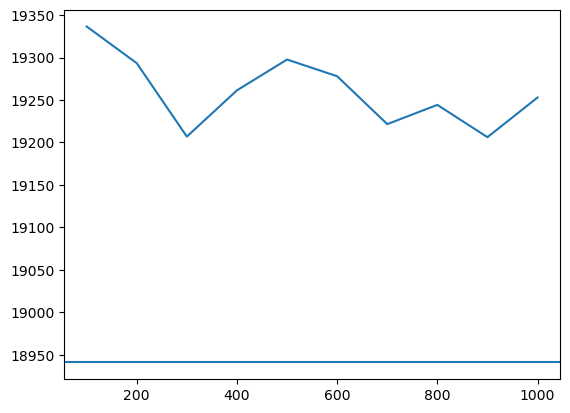

In [881]:
pp.plot(range(100,1100,100), clogls2)
pp.axhline(logl(p0))

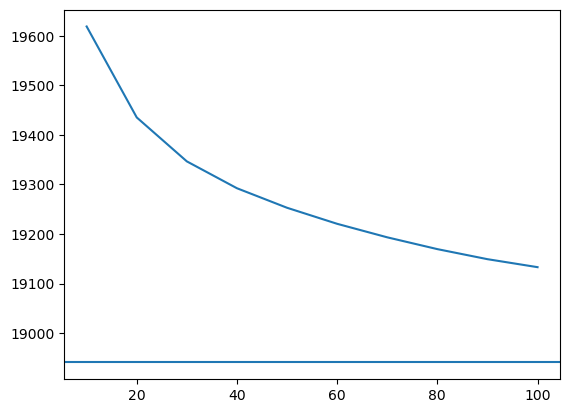

In [879]:
pp.plot(range(10,110,10), clogls)
pp.axhline(logl(p0))

In [873]:
logl = jax.jit(model.logL)
logl(p0)

Array(18940.87119336, dtype=float64)

In [759]:
p0 = ds.sample_uniform(logl.params)

In [760]:
%timeit logl(p0)

10.2 ms ± 397 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [781]:
clogl = model.cglogL(1000)
clogl(p0)

NameError: name 'jnp' is not defined

In [776]:
import matfree
from matfree import decomp, funm, stochtrace

In [777]:
num_matvecs = 3
tridiag_sym = decomp.tridiag_sym(num_matvecs)
problem = funm.integrand_funm_sym_logdet(tridiag_sym)
x_like = jnp.ones((nrows,), dtype=float)
sampler = stochtrace.sampler_normal(x_like, num=1_000)
estimator = stochtrace.estimator(problem, sampler=sampler)
logdet = estimator(matvec, jax.random.PRNGKey(1))
print(logdet)

NameError: name 'x_like' is not defined

In [773]:
matfree.slq

AttributeError: module 'matfree' has no attribute 'slq'

In [771]:
from matfree.trace_estimation import slq

ModuleNotFoundError: No module named 'matfree.trace_estimation'

In [765]:
clogl = model.cglogL(1000)
clogl(p0)

AttributeError: module 'matfree.stochtrace' has no attribute 'slq'

In [751]:
clogl = jax.jit(model.cglogL(1000))
clogl(p0)

Array(885734.59151144, dtype=float64)

In [752]:
%timeit clogl(p0)

18.6 ms ± 48.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [122]:
%time logl(p0).block_until_ready()

CPU times: user 128 ms, sys: 231 ms, total: 359 ms
Wall time: 64.8 ms


Array(3562941.71161567, dtype=float64)

In [125]:
%timeit logl(p0).block_until_ready()

64.2 ms ± 472 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [127]:
jlogl = jax.jit(jax.value_and_grad(logl))

In [130]:
%time jlogl(p0)[0].block_until_ready()

CPU times: user 740 ms, sys: 305 ms, total: 1.04 s
Wall time: 145 ms


Array(3563151.53169641, dtype=float64)

In [131]:
%timeit jlogl(p0)[0].block_until_ready()

118 ms ± 383 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [534]:
Phimat = model.globalgp.Phi.getN(p0)

In [535]:
Phiinv, detPhi = model.globalgp.Phi_inv(p0)

In [536]:
orfmat = ds.matrix.jnparray([[ds.hd_orf(p1.pos, p2.pos) for p1 in allpsrs[:5]] for p2 in allpsrs[:5]])
invorf = jnp.linalg.inv(orfmat)

In [537]:
phi = Phimat[:61,:61]
invphi = jnp.linalg.inv(phi)
invPhi = jnp.block([[jnp.make2d(val * invphi) for val in row] for row in invorf])

In [538]:
Phiinv = jnp.linalg.inv(Phimat[:61*5,:61*5])

In [539]:
jnp.allclose(Phiinv, invPhi)

Array(True, dtype=bool)

In [665]:
phicf = jax.scipy.linalg.cho_factor(phi)

In [666]:
orfcf = jax.scipy.linalg.cho_factor(orfmat)

In [680]:
def matvec3(orfcf, phicf, FtNmF):
    def apply(FtNmy):
        term1 = jax.scipy.linalg.cho_solve(orfcf, jax.scipy.linalg.cho_solve(phicf, FtNmy.T).T)
        term2 = jnp.einsum('kij,kj->ki', FtNmF, FtNmy)
        return term1 + term2

    return apply

In [540]:
FtNmy = np.random.randn(5*61).reshape(5,61)

In [541]:
FtNmF = np.random.randn(5,61,61)
FtNmF = 0.5 * (FtNmF + np.swapaxes(FtNmF, 1, 2))

In [533]:
# invphi = 0.5 * (invphi + invphi.T)
# invorf = 0.5 * (invorf + invorf.T)

In [569]:
def matvec(invorf, invphi, FtNmF):
    def apply(FtNmy):
        # return jnp.einsum('lk,ki->li', invorf, jnp.einsum('ij,kj->ki', invphi, FtNmy))
        # return invorf @ jnp.einsum('ij,kj->ki', invphi, FtNmy)
        # return jnp.einsum('lk,ij,kj->li', invorf, invphi, FtNmy)
        return jnp.einsum('kl,ij,lj->ki', invorf, invphi, FtNmy) + jnp.einsum('kij,kj->ki', FtNmF, FtNmy)

    return apply

In [632]:
def matvec2(invorf, invphi, FtNmF):
    @jax.jit
    def apply(FtNmy):
        return invorf @ FtNmy @ invphi.T + jnp.einsum('kij,kj->ki', FtNmF, FtNmy)
    
    return apply

In [690]:
matvec3(orfcf, phicf, FtNmF)(FtNmy)[1,:10]

Array([ 5.46434395e+19, -2.09103986e+20,  3.76796681e+20, -4.71736817e+20,
        5.07572906e+20, -5.06365776e+20,  4.67263378e+20, -3.77637864e+20,
        2.43922535e+20, -1.23418910e+20], dtype=float64)

In [689]:
matvec2(invorf, invphi, FtNmF)(FtNmy)[1,:10]

Array([ 5.46434396e+19, -2.09103986e+20,  3.76796681e+20, -4.71736817e+20,
        5.07572906e+20, -5.06365776e+20,  4.67263379e+20, -3.77637865e+20,
        2.43922535e+20, -1.23418911e+20], dtype=float64)

In [688]:
matvec(invorf, invphi, FtNmF)(FtNmy)[1,:10]

Array([ 5.46434396e+19, -2.09103986e+20,  3.76796681e+20, -4.71736817e+20,
        5.07572906e+20, -5.06365776e+20,  4.67263379e+20, -3.77637865e+20,
        2.43922535e+20, -1.23418911e+20], dtype=float64)

In [694]:
sol = jaxopt.linear_solve.solve_cg(matvec3(orfcf, phicf, FtNmF), FtNmy, maxiter=20000)

In [698]:
jnp.sum(sol * FtNmy)

Array(1.96560467e-12, dtype=float64)

In [589]:
sigma = invPhi + jax.scipy.linalg.block_diag(*FtNmF)

In [592]:
Y = FtNmy.reshape(5 * 61)

In [593]:
sigma @ Y - matvec2(invorf, invphi, FtNmF)(FtNmy).reshape(5 * 61)

Array([   -512.,   -8192.,    8192.,  -28672.,  -26624.,  -16384.,
        -20480.,  -16384.,  -36864.,  180224.,   -4096.,  -12288.,
        -14336.,  -61440., -251904.,    8192.,  114688.,  262144.,
        -16384.,  -49152.,   57344.,   24576.,   16384.,   57344.,
        -65536.,   49152., -163840.,  327680.,  131072.,  -49152.,
         57344.,  -89088.,   -4096.,  -61440.,   16384.,  -98304.,
        -65536.,   32768., -327680.,   32768.,  -32768., -114688.,
        -73728.,       0.,   18432.,  -26624.,  168960.,  -49152.,
             0.,  -98304.,  -65536., -229376.,  196608.,  -65536.,
        327680.,   65536., -131072.,   65536.,       0.,  114688.,
         16384.,   -8192.,       0.,  131072., -393216.,  196608.,
        196608.,  -65536.,       0.,   65536.,   32768.,   32768.,
        -16384.,  -65536., -163840.,  -32768.,   53248., -196608.,
        -98304., -196608.,  -98304.,   65536.,  -65536.,  -32768.,
        -32768.,  -16384.,   49152.,       0.,  131072.,      

In [548]:
m1 = matvec(invorf, invphi, FtNmF)
%timeit m1(FtNmy)

110 μs ± 414 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [648]:
m2 = matvec2(invorf, invphi, FtNmF)
m2(FtNmy)
%timeit m2(FtNmy)

7.37 μs ± 52.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [646]:
%time jnp.linalg.solve(sigma, Y)[:50].block_until_ready()

CPU times: user 5.82 ms, sys: 19 ms, total: 24.9 ms
Wall time: 8.52 ms


Array([ 3.10286097e-15, -2.03843897e-15, -7.26843340e-15, -1.25109174e-14,
       -1.76868895e-14, -2.27157693e-14, -2.75164852e-14, -3.20081264e-14,
       -3.61111847e-14, -3.97497703e-14, -4.28538802e-14, -4.53618808e-14,
       -4.72231515e-14, -4.84000349e-14, -4.88685748e-14, -4.86180199e-14,
       -4.76499189e-14, -4.59776898e-14, -4.36263846e-14, -4.06321279e-14,
       -3.70409500e-14, -3.29070795e-14, -2.82912863e-14, -2.32588248e-14,
       -1.78780767e-14, -1.22209762e-14, -6.36418745e-15, -3.89649274e-16,
        5.61607385e-15,  1.15631918e-14,  1.73592404e-14,  2.29104204e-14,
        2.81240402e-14,  3.29113564e-14,  3.71899900e-14,  4.08862219e-14,
        4.39373705e-14,  4.62935095e-14,  4.79192655e-14,  4.87955049e-14,
        4.89193060e-14,  4.83023008e-14,  4.69677785e-14,  4.49481111e-14,
        4.22846513e-14,  3.90285607e-14,  3.52406425e-14,  3.09908660e-14,
        2.63580724e-14,  2.14288496e-14], dtype=float64)

In [652]:
import jaxopt
jaxopt.linear_solve.solve_normal_cg

<function jaxopt._src.linear_solve.solve_normal_cg(matvec: Callable, b: Any, ridge: Optional[float] = None, init: Optional[Any] = None, **kwargs) -> Any>

In [663]:
%time jaxopt.linear_solve.solve_cg(m2, FtNmy, maxiter=20000).block_until_ready()

CPU times: user 159 ms, sys: 11.7 ms, total: 171 ms
Wall time: 168 ms


Array([[ 3.10090580e-15, -2.04056289e-15, -7.27070214e-15,
        -1.25133040e-14, -1.76893646e-14, -2.27183012e-14,
        -2.75190408e-14, -3.20106714e-14, -3.61136843e-14,
        -3.97521888e-14, -4.28561819e-14, -4.53640305e-14,
        -4.72251152e-14, -4.84017801e-14, -4.88700722e-14,
        -4.86192435e-14, -4.76508472e-14, -4.59783060e-14,
        -4.36266770e-14, -4.06320899e-14, -3.70405803e-14,
        -3.29063817e-14, -2.82902690e-14, -2.32575015e-14,
        -1.78764656e-14, -1.22190999e-14, -6.36207295e-15,
        -3.87327124e-16,  5.61856999e-15,  1.15658258e-14,
         1.73619748e-14,  2.29132165e-14,  2.81268590e-14,
         3.29141587e-14,  3.71927369e-14,  4.08888750e-14,
         4.39398927e-14,  4.62958656e-14,  4.79214229e-14,
         4.87974345e-14,  4.89209824e-14,  4.83037029e-14,
         4.69688900e-14,  4.49489201e-14,  4.22851505e-14,
         3.90287472e-14,  3.52405177e-14,  3.09904355e-14,
         2.63573460e-14,  2.14278411e-14,  1.62936744e-1

In [269]:
from jaxopt.linear_solve import solve_cg

In [385]:
jnp.unique((matvec(invorf, invphi, FtNmF)(FtNmy) - matvec2(invorf, invphi, FtNmF)(FtNmy)).reshape(30*61))

Array([-16384.,  -8192.,  -4096.,  -2048.,  -1024.,      0.,    512.,
         1024.,   2048.,   4096.,   8192.], dtype=float64)

In [397]:
%timeit solve_cg(matvec2(invorf, invphi, FtNmF), FtNmy).reshape(30 * 61)

446 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [391]:
matvec(invorf, invphi, FtNmF)(FtNmy).reshape(30 * 61) - (invPhi + jax.scipy.linalg.block_diag(*FtNmF)) @ FtNmy.reshape(30 * 61)

Array([   8192.,  212992., -778240., ...,  -32768.,       0.,   -4096.],      dtype=float64)

In [295]:
(invPhi + jax.scipy.linalg.block_diag(*FtNmF)) @ FtNmy.reshape(30 * 61)

Array([ 2.34771261e+19, -7.11230689e+19,  7.48679396e+19, ...,
       -5.61964122e+19,  3.89658002e+19, -1.14413039e+19], dtype=float64)

In [398]:
%timeit cf = jax.scipy.linalg.cho_factor(invPhi + jax.scipy.linalg.block_diag(*FtNmF))

38.4 ms ± 454 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [399]:
%timeit jax.scipy.linalg.cho_solve(cf, FtNmy.reshape(30 * 61))

3.88 ms ± 101 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [218]:
jnp.einsum('ij,ki->kj', invphi, FtNmy)

(30, 61)